**CZ4003: Text Image Segmentation for Optimal Optical character recognition**

Authors: Chulpaibul Jiraporn (U1822666H), Deng Jinyang (U1820375G)

In [1]:
import pytesseract
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

image_1_path = "sample_images/sample01.png"
image_2_path = "sample_images/sample02.png"

sample_1 = cv2.imread(image_1_path, 0)
sample_2 = cv2.imread(image_2_path, 0)

In [2]:
# Helper Functions
def print_text(image):
    print(pytesseract.image_to_string(image))

def contrast_stretching(image):
  max_x = image.max()
  min_x = image.min()
  contrast_image = 255.0*(image - min_x)/(max_x-min_x)
  return contrast_image.astype(np.uint8)

**Part 1**

Implement the Ostu global thresholding algorithm for binarizing the sample text images and feed the binarized images to the OCR software to evaluate the OCR accuracy. Discuss any problems with the Otsu global thresholding algorithm.

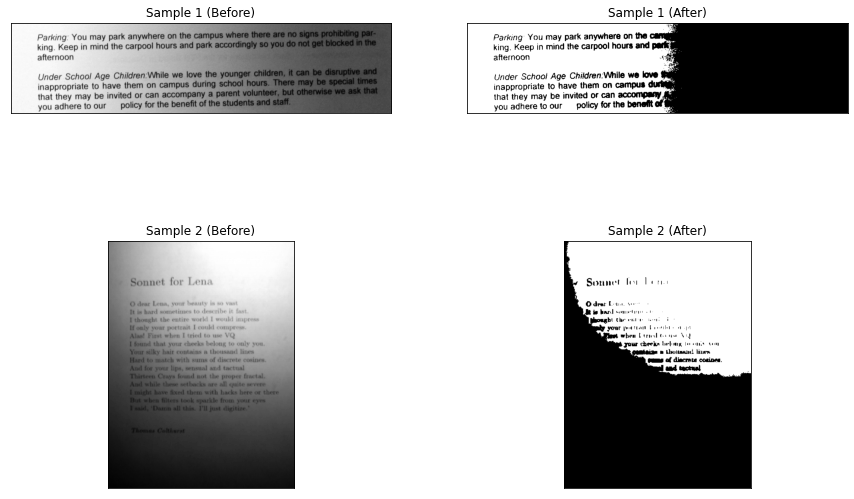

In [3]:
def otsu_algo(image):
    total_pixel_count = image.flatten().shape[0]
    total_var = image.flatten().var()
    hist = [np.sum(image == i) for i in range(0, 256)]
    hist_prob = [_ / total_pixel_count for _ in hist]

    intra_class_vars, inter_class_vars = [],[]

    for i in range(0, 256):
        lower_prob, higher_prob = sum(hist_prob[:i]), sum(hist_prob[i:])

        lower_mean = 1/lower_prob * sum([j * hist_prob[j] for j in range(0, i)]) if lower_prob > 0 else 0
        higher_mean = 1/higher_prob * sum([j * hist_prob[j] for j in range(i, 256)]) if higher_prob > 0 else 0

        lower_var = 1/lower_prob * sum([(j - lower_mean)**2 * hist_prob[j] for j in range(0, i)]) if lower_prob > 0 else 0
        higher_var = 1/higher_prob * sum([(j - higher_mean)**2 * hist_prob[j] for j in range(i, 256)]) if higher_prob > 0 else 0

        intra_class_var = lower_prob * lower_var + higher_prob * higher_var
        inter_class_var = lower_prob * higher_prob * (lower_mean - higher_mean)**2
        assert round(inter_class_var + intra_class_var, 7) == round(total_var, 7)
        intra_class_vars.append(intra_class_var)
        inter_class_vars.append(inter_class_var)

    return(intra_class_vars, inter_class_vars)

def apply_thresh_on_image(image, thresh):
    new_image = image.copy()
    new_image[image > thresh] = 255
    new_image[image <= thresh] = 0
    return new_image

def process_image(image):
    intra_class_vars, inter_class_vars = otsu_algo(image)
    assert intra_class_vars.index(min(intra_class_vars)) == inter_class_vars.index(max(inter_class_vars)) 
    thresh = intra_class_vars.index(min(intra_class_vars)) - 1
    processed_image = apply_thresh_on_image(image, thresh)
    return (thresh, processed_image)

sample_1_thresh, sample_1_processed = process_image(sample_1)
sample_2_thresh, sample_2_processed = process_image(sample_2)

plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1), plt.imshow(sample_1, 'gray'), plt.title("Sample 1 (Before)"), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 2), plt.imshow(sample_1_processed, 'gray'), plt.title("Sample 1 (After)"), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 3), plt.imshow(sample_2, 'gray'), plt.title("Sample 2 (Before)"), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 4), plt.imshow(sample_2_processed, 'gray'), plt.title("Sample 2 (After)"), plt.xticks([]), plt.yticks([])
plt.show()

In [4]:
# Comparing our results with the official otsu implementation
ret1, sample_1_otsu = cv2.threshold(sample_1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
ret2, sample_2_otsu = cv2.threshold(sample_2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print(np.any((sample_1_processed == sample_1_otsu) == True))
print(np.any((sample_2_processed == sample_2_otsu) == True))
print(sample_1_thresh == ret1)
print(sample_2_thresh == ret2)

True
True
True
True


In [5]:
# Before processing
print("Sample01.png before Otsu")
print_text(sample_1)
print("Sample02.png before Otsu")
print_text(sample_2)

Sample01.png before Otsu
Parking: You may park anywhere on the ce
king. Keep in mind the carpool hours and park
afternoon

Under School Age Children:While we love
inappropriate to have them on campus @ )
that they may be invited or can accompany :
you adhere to our _ policy for the benefit of

 

Sample02.png before Otsu
Sonnet for Lena

 



In [6]:
# After processing
print("Sample01.png after Otsu\n")
print_text(sample_1_processed)
print("Sample02.png after Otsu\n")
print_text(sample_2_processed)

Sample01.png after Otsu

Parking You may park anywhere on the cf
king. Keep in mind the carpool hours and peri,
afternoon

Under School Age Children:While we love
inappropriate to have them on campus @ i
that they may be invited or can accompany J
you adhere to our —_policy for the benefit of

 

Sample02.png after Otsu

Sonnet for ler

 



**Part 2**

Design your own algorithms to address the problem of Otsu global thresholding algorithm, and evaluate OCR accuracy for the binary images as produced by your algorithms. You may explore different approaches such as adaptive thresholding, image enhancement, etc., and the target is to achieve the best OCR accuracy.

Our approach:


1.   Adaptive Gaussian Thresholding + Gaussian Blurring
2.   Background Layer Removal

We will also provide an alternative way to generate background for the sample images.




**Part 2.1 - Adaptive Gaussian Thresholding + Gaussian Blurring**

In [7]:
def method_1(image):
    # Step 1: Gaussian Adaptive Threshold
    step_1_result = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,19,5)
    # Step 2: Gaussian Blur
    step_2_result = cv2.GaussianBlur(step_1_result,(3,3),3)
    
    return step_2_result

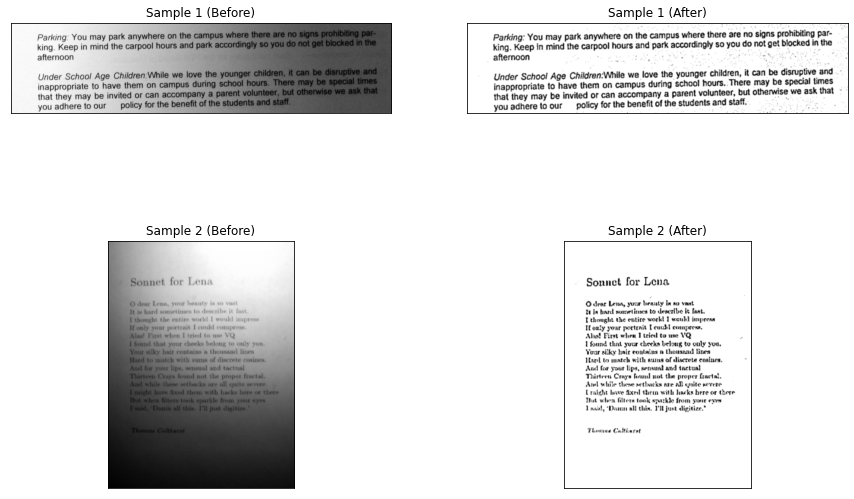

In [8]:
sample_1_method_1 = method_1(sample_1)
sample_2_method_1 = method_1(sample_2)

plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1), plt.imshow(sample_1, 'gray'), plt.title("Sample 1 (Before)"), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 2), plt.imshow(sample_1_method_1, 'gray'), plt.title("Sample 1 (After)"), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 3), plt.imshow(sample_2, 'gray'), plt.title("Sample 2 (Before)"), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 4), plt.imshow(sample_2_method_1, 'gray'), plt.title("Sample 2 (After)"), plt.xticks([]), plt.yticks([])
plt.show()

In [9]:
# After processing
print("Sample01.png after Adaptive Gaussian Thresholding + Gaussian Blur\n")
print_text(sample_1_method_1)
print("Sample02.png after Adaptive Gaussian Thresholding + Gaussian Blur\n")
print_text(sample_2_method_1)

Sample01.png after Adaptive Gaussian Thresholding + Gaussian Blur

Parking: You may park anywhere on the campus where there are no signs prohibiting par-
king. Keep in mind the carpool hours and park accordingly so you do not get blocked in the
afternoon - : .

Under School Age Children:While we love the younger children, it can be disruptive and
inappropriate to have them on campus during school hours. There may be special times
that they may be invited or can accompany a parent volunteer, but otherwise we ask that
you adhere to our policy for the benefit of the students and staff.

Sample02.png after Adaptive Gaussian Thresholding + Gaussian Blur

Sonnet for Lena

O dear Lena, your beauty in so vast

te in harct sometinaes to deseribe it fant.
Tthought the entice work! 1 would ianpress
If only your portrait [ coukl comprens,

Alas! First when T trict! to use VQ

1 found that your cheeks belong to only you.
Your silky haic coulalns a thousand lines
Hard to match with suing of discret

**Part 2.2 - Background Layer Removal**

In [10]:
def method_2(image):
    mask = image.copy()
    mask = cv2.Canny(mask, 30, 50)
    kernel = np.ones((3,3),np.uint8)
    mask = cv2.dilate(mask, kernel ,iterations = 1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    background = image.copy()
    background = cv2.inpaint(background, mask, 3, cv2.INPAINT_TELEA) 
    background = cv2.inpaint(background, mask, 100, cv2.INPAINT_TELEA)    
    new_background = cv2.GaussianBlur(background, (3,3), 2)
    new_image = image / new_background
    norm_new_image = contrast_stretching(new_image)

    return norm_new_image

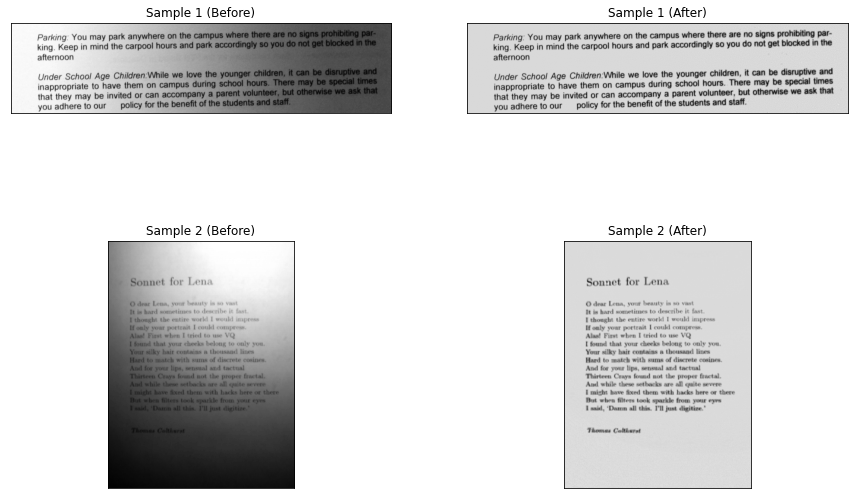

In [11]:
sample_1_method_2 = method_2(sample_1)
sample_2_method_2 = method_2(sample_2)

plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1), plt.imshow(sample_1, 'gray'), plt.title("Sample 1 (Before)"), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 2), plt.imshow(sample_1_method_2, 'gray'), plt.title("Sample 1 (After)"), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 3), plt.imshow(sample_2, 'gray'), plt.title("Sample 2 (Before)"), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 4), plt.imshow(sample_2_method_2, 'gray'), plt.title("Sample 2 (After)"), plt.xticks([]), plt.yticks([])
plt.show()

In [12]:
# After processing
print("Sample01.png after Background Layer Removal\n")
print_text(sample_1_method_2)
print("Sample02.png after Background Layer Removal\n")
print_text(sample_2_method_2)

Sample01.png after Background Layer Removal

Parking: You may park anywhere on the campus where there are no signs prohibiting par-
king. Keep in mind the carpool hours and park accordingly so you do not get blocked in the
afternoon

Under School Age Children:While we love the younger children, it can be disruptive and
inappropriate to have them on campus during school hours. There may be special times
that they may be invited or can accompany a parent volunteer, but otherwise we ask that
you adhere to our _ policy for the benefit of the students and staff.

Sample02.png after Background Layer Removal

Sonnet for Lena

© dear Lena, your beauty is so vast

It is hard sometimes to describe it fast,

I thought the entire world | would impress
If only your portrait | could compress.

Alas! First when I tried to use VQ

I found that your cheeks belong to only you.
Your silky hair contains a thousand lines
Hard to match with sums of discrete cosines.
And for your lips, sensual and tactual
T

**Part 2.3 - An Alternative Method for Background Layer Reconstruction**

This offers a much more simplified approach as compared to the previous algorithm,  as it does not requrie the tuning of many parameters, and is capable of achieving similar performance in a much shorter time.

In [13]:
def method_3(image):
    background = cv2.GaussianBlur(image, (75, 75), 20)
    new_image = image / background
    norm_new_image = contrast_stretching(new_image)
    return norm_new_image

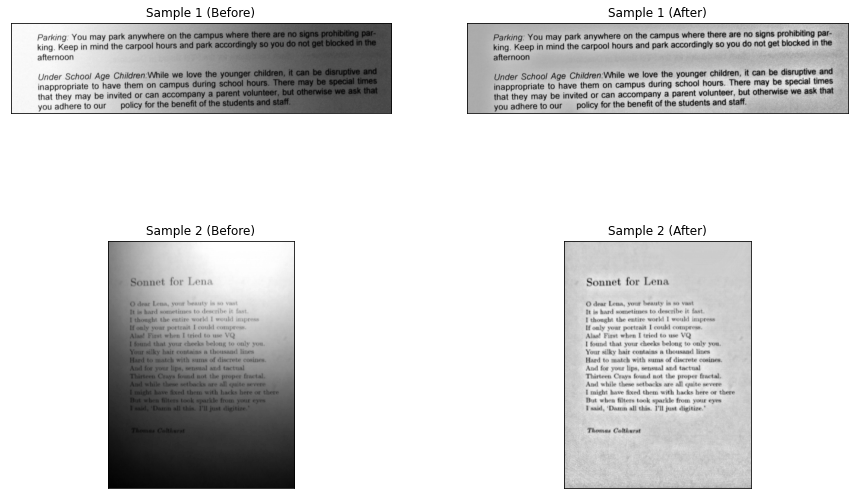

In [14]:
sample_1_method_3 = method_3(sample_1)
sample_2_method_3 = method_3(sample_2)

plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1), plt.imshow(sample_1, 'gray'), plt.title("Sample 1 (Before)"), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 2), plt.imshow(sample_1_method_3, 'gray'), plt.title("Sample 1 (After)"), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 3), plt.imshow(sample_2, 'gray'), plt.title("Sample 2 (Before)"), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 4), plt.imshow(sample_2_method_3, 'gray'), plt.title("Sample 2 (After)"), plt.xticks([]), plt.yticks([])
plt.show()

In [15]:
# After processing
print("Sample01.png after Method 3\n")
print_text(sample_1_method_3)
print("Sample02.png after Method 3\n")
print_text(sample_2_method_3)

Sample01.png after Method 3

Parking: You may park anywhere on the campus where there are no signs prohibiting par-
king. Keep in mind the carpool hours and park accordingly so you do not get blocked in the
afternoon

Under School Age Children:While we love the younger children, it can be disruptive and
inappropriate to have them on campus during school hours. There may be special times
that they may be invited or can accompany a parent volunteer, but otherwise we ask that
you adhere to our _ policy for the benefit of the students and staff.

Sample02.png after Method 3

Sonnet for Lena

© dear Lena, your beauty is so vast

It is hard sometimes to describe it fast,

I thought the entire world | would impress
If only your portrait [ could compress.

Alas! First when I tried to use VQ

I found that your cheeks belong to only you,
Your silky hair contains a thousand lines
Hard to match with sums of discrete cosines.
And for your lips, sensual and tactual
Thirteen Crays found not the prop

**Part 3**

Discuss how to improve recognition algorithms for more robust and accurate character recognition while document images suffer from different types of image degradation. This is an open and optional task. There will be bonus points if you have good ideas on it.

In this section we will be proposing three novel ideas, which we believe will lead to an improved OCR performance:

1.   Location-Aware Correction
2.   A Search-Based Pre-Processing Approach*
3.   Bounding Box Adjustment

*Not demonstrated here

**Part 3.1 - Location-Aware Correction**

By performing OCR on a snippet of the image, rather than the entire image, we can get more accurate results.

What were "world |" and "| could" (from Part 2.2) have become "world I" and "I could".

world I
I could



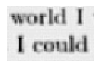

In [16]:
plt.figure(figsize = (20, 1))
plt.axis('off')
plt.imshow(sample_2_method_2[240:290, 260:340], cmap = 'gray')
print_text(sample_2_method_2[240:290, 260:340])

**Part 3.3 - Bound Box Adjustment**

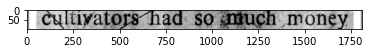

In [17]:
vandalized = cv2.imread('sample_images/vandalized_document.png')[50:150,:]
vandalized_copy = vandalized.copy()

# Before adjusting for bounding boxes, we cannot get any detection.
plt.imshow(vandalized)
print_text(vandalized)

| Cultivators ihad| So|amucn |

 



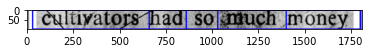

In [18]:
# Even by just introducing bounding boxes, we can already see an improvement
cv2.rectangle(vandalized, (30, 0), (660, 100), (0,0,255), 5)
cv2.rectangle(vandalized, (660, 0), (860, 100), (0,0,255), 5)
cv2.rectangle(vandalized, (860, 0), (1030, 100), (0,0,255), 5)
cv2.rectangle(vandalized, (1030, 0), (1400, 100), (0,0,255), 5)
cv2.rectangle(vandalized, (1400, 0), (1800, 100), (0,0,255), 5)
plt.imshow(vandalized)
print_text(vandalized)

(<matplotlib.image.AxesImage at 0x1c6cd7b0cd0>,
 Text(0.5, 1.0, 'money'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

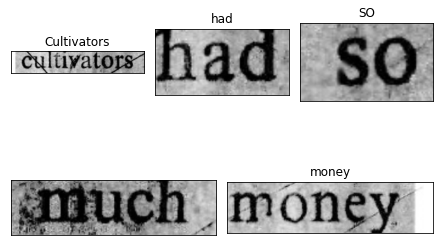

In [19]:
# Going one step further into individual boxes
part_1 = vandalized_copy[0:100, 30:660]
part_1_result = pytesseract.image_to_string(part_1)

part_2 = vandalized_copy[0:100, 660:860]
part_2_result = pytesseract.image_to_string(part_2)

part_3 = vandalized_copy[0:100, 860:1030]
part_3_result = pytesseract.image_to_string(part_3)

part_4 = vandalized_copy[0:100, 1030:1400]
part_4_result = pytesseract.image_to_string(part_4)

part_5 = vandalized_copy[0:100, 1400:1800]
part_5_result = pytesseract.image_to_string(part_5)

fig2 = plt.figure(constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=6, nrows=2, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0:2])
plt.imshow(part_1, 'gray'), plt.title(part_1_result.strip()), plt.xticks([]), plt.yticks([])
f2_ax2 = fig2.add_subplot(spec2[0, 2:4])
plt.imshow(part_2, 'gray'), plt.title(part_2_result.strip()), plt.xticks([]), plt.yticks([])
f2_ax3 = fig2.add_subplot(spec2[0, 4:6])
plt.imshow(part_3, 'gray'), plt.title(part_3_result.strip()), plt.xticks([]), plt.yticks([])
f2_ax4 = fig2.add_subplot(spec2[1, 0:3])
plt.imshow(part_4, 'gray'), plt.title(part_4_result.strip()), plt.xticks([]), plt.yticks([])
f2_ax5 = fig2.add_subplot(spec2[1, 3:6])
plt.imshow(part_5, 'gray'), plt.title(part_5_result.strip()), plt.xticks([]), plt.yticks([])